In [45]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
%matplotlib inline
import random
import scipy.sparse as sps

/specific/fprivate/bnet/danasilv/python_venv/lib/python3.4/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy.linalg as la

In [4]:
from sklearn.metrics import precision_recall_curve
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

/specific/fprivate/bnet/danasilv/python_venv/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Classes and Functions

# Network diffusion

Class network performs network diffusion (RWR) as descrived in Cowen et al.
To use: 
    Initialization steps (done only once per network)
    1. Create a network
    2. Normalize (done only once)
    Diffusion
    1. Prepare a prior vector
    2. run smooth (performs the diffusion)
    

In [5]:
class Network:
    def __init__(self, graph, allGenes, geneToRow):
        self.graph = graph
        self.size = graph.shape[0]
        self.allGenes = allGenes
        self.geneToRow = geneToRow
    
    
    def normalize(self):
        x = self.graph.sum(axis=1)
        x[x == 0] = 1
        x = 1.0 / x
        data = x
        d = sps.dia_matrix( (data.T,[0]), (len(data),len(data)) )
        self.graph = d * self.graph
        return self
    
    def smooth(self, y, alpha=0.6, eps=1e-5, max_iter=100):

        y = y.transpose()
        f = np.copy(y)
        for i in range(max_iter):
            fold = f
            f = alpha * f * self.graph + (1-alpha) * y
            if la.norm(f-fold) < eps:
                break
        return f

In [6]:
def read_ppi(PPI, is_undirected):
    
    # Read the PPI network and perform edge reweighting by gene expression
    fromArr = PPI['ID1'].astype(str).tolist()
    toArr = PPI['ID2'].astype(str).tolist()
    confidenceArr = PPI['conf'].tolist()

    geneToRow = {}
    allGenes = list(set(fromArr + toArr))
    i = 0
    for gene in allGenes:
        geneToRow[gene] = i
        i += 1

    for i in range(len(fromArr)):
        fromArr[i] = geneToRow[fromArr[i]]
        toArr[i] = geneToRow[toArr[i]]

    n = len(allGenes)
    d = sps.coo_matrix((confidenceArr, (fromArr, toArr)), shape=(n,n))
    # to make network undirected use this
    if (is_undirected == True):
        sym = d + d.T
    # to make network directed use this
    else:
        sym = d
    print ("%d genes in the network" % (len(allGenes,)))
    return Network(sym, allGenes, geneToRow)

Calculates D2D scorefor an edge 
input:
ID1 - head of the interaction
ID2 - tail of the interaction
network diffusion from sources - output of the function smooth
network diffusion from terminals - output of the function smooth
geneToRow - mapping from the network to the class Network - property of the class Netowrk

In [7]:
def calc_score_for_edge(ID1,ID2,diffuse_from_sources,diffuse_from_terminals, geneToRow):
    Fc_u = diffuse_from_sources.T[geneToRow[str(ID1)]][0]
    Fc_v = diffuse_from_sources.T[geneToRow[str(ID2)]][0]
    Fe_u = diffuse_from_terminals.T[geneToRow[str(ID1)]][0]
    Fe_v = diffuse_from_terminals.T[geneToRow[str(ID2)]][0]
    return (Fc_u * Fe_v)/(Fe_u * Fc_v)

Runs diffusion per experiment, diffusing once from the set of sources and once from their paired tarminals,
then calculates the score for eadh edge (the diffusion from the sources divided by the diffusion from the terminals)

In [8]:
def run_diffusion_for_experiment(experiment_name, sources, terminals, unoriented_network, unoriented):
    
    # Diffuse from the sources
    prior = np.zeros((unoriented_network.size,1))
    for gene in sources[sources['Experiment'] == experiment_name]['ID']:
        if gene in network_IDs:
            prior[unoriented_network.geneToRow[str(gene)]] = 1
    diffuse_from_sources = unoriented_network.smooth(prior, alpha = 0.6)

    # Diffuse from the terminals
    prior = np.zeros((unoriented_network.size,1))
    for gene in terminals[terminals['Experiment'] == experiment_name]['ID']:
        if gene in network_IDs:
            prior[unoriented_network.geneToRow[str(gene)]] = 1
    diffuse_from_terminals = unoriented_network.smooth(prior, alpha = 0.6)

    # Save the score
    unoriented[experiment_name] = unoriented.apply(lambda row: calc_score_for_edge(row['ID1'],row['ID2'], diffuse_from_sources, diffuse_from_terminals,unoriented_network.geneToRow), axis = 1)


# Build a classifier

Performs cross fold validation, reporting the precision and recall

In [9]:
def get_recall_precision(pred_name, pred_features, pred_true, pred_ID1, pred_ID2, clf, select, FOLDS = 3):
    
    k_fold_base= cross_validation.KFold(n=len(pred_true[pred_true == 2]), n_folds=FOLDS, shuffle=True,random_state=None)
         
    all_proba = []
    all_ytest = []
    all_names = []
   
    sum_coef_zero = 0
    
    # Choose folds so tonot mix the true instances with the same interactions' false
    folds = []
    for train_index, test_index in k_fold_base:       

        # Choose the corresponding false (this is done to prevent information leak caused by having one direction chosen
        # once in the test set and the opposite direction chosen for the training)
        EdgeTrue = (pred_ID2.iloc[train_index].astype(str) + "." + pred_ID1.iloc[train_index].astype(str))
        IdxFalse = pred_name[pred_name.isin(EdgeTrue)].index
        IdxFullTrain = np.append(IdxFalse.values, train_index)

        # The rest are the training
        IdxFullTest = pred_name[~pred_name.index.isin(IdxFullTrain)].index
        folds.append((IdxFullTrain, IdxFullTest))

    for train_index, test_index in folds:       

        xtrain, xtest = pred_features.loc[train_index], pred_features.loc[test_index]
        ytrain, ytest = pred_true.loc[train_index], pred_true.loc[test_index]
        name_test = pred_name.loc[test_index]
        xtrain = xtrain.rank(axis='columns')
        xtest = xtest.rank(axis='columns')
    
        test_prob = clf.fit(xtrain,ytrain).predict_proba(xtest)       
    
        all_proba.extend(test_prob)
        all_ytest.extend(ytest)
        all_names.extend(name_test)
        
    # roc_curve
    precision, recall, thresholds = precision_recall_curve(np.array(all_ytest), np.array(all_proba)[:,1], pos_label=2)                
    mean_auc = auc(recall, precision)
    rows, columns = pred_features.shape
    
    oriented_network = pd.concat([pd.DataFrame({'edge': all_names}), pd.DataFrame({'edge': all_ytest}), pd.DataFrame({'pval': np.array(all_proba)[:,1]})], axis = 1)
    oriented_network.columns = ['edge','true','pval']
    
    return recall, precision, mean_auc, oriented_network, np.array(all_proba)[:,1]

Prepares data for precision recall test

In [10]:
def test_crossfold(signal,col_list, set_type, clf, select, FOLDS = 3): 
    
    tested_set = read_set(signal, set_type)
   
    instances = tested_set[tested_set['true'] > 0].copy()
    instances = instances.reset_index(drop=True)
    
    # Calculate precision recall
    pred_true = instances['true']
    pred_ID1 = instances['ID1']
    pred_ID2 = instances['ID2']
    pred_features = instances[col_list]
    
    recall, precision, AUC, oriented_network, prob = get_recall_precision(instances['edge'], pred_features, pred_true, pred_ID1, pred_ID2, clf, select, FOLDS)
    return (recall, precision, AUC, oriented_network, prob)

Prepares the data for cross validation by marking the edges of the tested interactions

In [11]:
def read_set(original_network,  tested_interactions_type):
    
    original_network['true'] = -1
    true_ix = original_network[original_network['type'] == ('TRUE_' + tested_interactions_type)].index.tolist()
    false_ix = original_network[original_network['type'] == ('FALSE_' + tested_interactions_type)].index.tolist()
    # All sets
    original_network.loc[true_ix, 'true'] = 2
    original_network.loc[false_ix, 'true'] = 1
    return (original_network)

Calculates AUC for all five test sets: PDIs, KPIs, STKE, EGFR, E3

In [12]:
def print_auc(drugs, use, FOLDS = 3, repeats = 10):
    AUC1 = AUC2 = AUC3 = AUC4 = AUC5 = 0
    for i in range (1, repeats + 1):
        recall, precision, AUC, oriented_network, prob_pdi = test_crossfold(drugs,use,'balanced_pdi',linear_model.LogisticRegression(solver='liblinear', penalty = 'l1', C=0.01),0, FOLDS)
        AUC2 += AUC
    print("PDIs %.2f"%(AUC2/repeats))
    
    for i in range (1, repeats + 1):
        recall, precision, AUC, oriented_network, prob_kpi = test_crossfold(drugs,use,'balanced_kpi',linear_model.LogisticRegression(solver='liblinear', penalty = 'l1', C=0.01),0, FOLDS)
        AUC1 += AUC
    print("KPIs %.2f"%(AUC1/repeats))
    
    for i in range (1, repeats + 1):
        recall, precision, AUC, oriented_network, prob_STKE = test_crossfold(drugs,use, 'STKE', linear_model.LogisticRegression(solver='liblinear', penalty = 'l1', C=1000),0, FOLDS)
        AUC3 += AUC
    print("STKE %.2f"%(AUC3/repeats))
    
    for i in range (1, repeats + 1):
        recall, precision, AUC, oriented_network, prob_EGFR = test_crossfold(drugs,use,'EGFR',linear_model.LogisticRegression(solver='liblinear', penalty = 'l1', C=100),0, FOLDS)
        AUC4 += AUC
    print("EGFR %.2f"%(AUC4/repeats))
    
    for i in range (1, repeats + 1):
        recall, precision, AUC, oriented_network, prob_E3 = test_crossfold(drugs,use,'E3',linear_model.LogisticRegression(solver='liblinear', penalty = 'l1', C=0.01),0, FOLDS)
        AUC5 += AUC
    print("E3 %.2f"%(AUC5/repeats))
    
    return ([(AUC2/repeats), (AUC1/repeats), (AUC3/repeats), (AUC4/repeats), (AUC5/repeats)])

# Create an oriented network

Takes a network for which the network diffusion scores were calculated and returns an oriented network with
D2D scores for each edge

In [13]:
def create_oriented_network_from_signal(signal, feature):
    
    netwrok_results = calc_D2D_for_unoriented_portion(signal, feature)
    netwrok_results.replace(0,0.0000001, inplace = True)
    oriented_network = netwrok_results[['edge','conf','pval','true','type']]
    choose_edge_network = choose_edge_direction(oriented_network)
    choose_edge_network['ID1'] = choose_edge_network.apply(lambda row: row['edge'].split('.')[0],  axis=1)
    choose_edge_network['ID2'] = choose_edge_network.apply(lambda row: row['edge'].split('.')[1],  axis=1)
    choose_edge_network['ID1'] =  choose_edge_network['ID1'].astype('int64')
    choose_edge_network['ID2'] =  choose_edge_network['ID2'].astype('int64')
    return (choose_edge_network)

Per interaction, compare the probabilty inferred for each direction, choose the edge with the highest probabilty, 
i.e. max(D2D(u,v),D2D(v,u)). 
For the chosen direction calculate the ratio of its probability with its opposite, i.e. the return (max(D2D(u,v),D2D(v,u)) / min(D2D(u,v),D2D(v,u)))

In [14]:
def choose_edge_direction(test_set):
       
    test_set['oppedge'] = test_set.apply(lambda row: row['edge'].split('.')[1] + "." + row['edge'].split('.')[0], axis=1)
    set_pred_merged = test_set.merge(test_set, left_on = 'edge', right_on = 'oppedge', how = 'inner')
    
    set_choose = set_pred_merged.apply(lambda row: 
            pd.Series((row['edge_x'],row['type_x'],row['conf_x'], (row['pval_x']/row['pval_y'])) if row['pval_x'] >= row['pval_y'] 
                      else (row['edge_y'], row['type_y'],row['conf_y'],(row['pval_y']/row['pval_x']))), axis=1 ) 

    set_choose.columns = ['edge','type','conf','probability']
    set_choose = set_choose.drop_duplicates()
    return (set_choose)

The function trains a classifier on all test edges, 
then uses the classifier to assign D2D scores for each iof the unoriented edges

In [15]:
def calc_D2D_for_unoriented_portion(current_signal, features, DataBase = 'biogrid'): 
    
    # Prepare training and test sets
    diffuse = current_signal.copy()
    diffuse = diffuse[diffuse['type'].str.endswith(DataBase) | 
                    diffuse['type'].str.endswith('balanced_pdi') | 
                    diffuse['type'].str.endswith('balanced_kpi') | 
                    diffuse['type'].str.endswith('balanced_E3') | 
                    diffuse['type'].str.endswith('EGFR') | 
                    diffuse['type'].str.endswith('STKE')]
    diffuse['true'] = -1

    # Use all sets as training
    true_ix = diffuse[diffuse['type'].str.startswith('TRUE')].index.tolist()
    false_ix = diffuse[diffuse['type'].str.startswith('FALSE')].index.tolist()
    diffuse.loc[true_ix, 'true'] = 2
    diffuse.loc[false_ix, 'true'] = 1
    train_ix = diffuse[diffuse['true'] > 0].index.tolist()
    test_ix = diffuse[diffuse['true'] == -1].index.tolist()

    #Train the network using all sets and all drugs
    # Infer orientation
    xtrain = diffuse.loc[train_ix,features]
    xtest = diffuse.loc[test_ix,features]
    ytrain = diffuse.loc[train_ix,'true']
    test_prob = clfLRL1.fit(xtrain,ytrain).predict_proba(xtest) 
    diffuse['pval'] = -1
    diffuse.loc[test_ix,'pval'] = test_prob[:,1]
    diffuse.loc[true_ix,'pval'] = 1
    diffuse.loc[false_ix,'pval'] = 0
    diffuse_test = diffuse[diffuse['type'] == DataBase]
    diffuse_train = diffuse[(diffuse['type'] != DataBase)]
    
    # Concat all training edges (including unbalanced)
    diffuse_train_true = current_signal[current_signal['type'].str.startswith('TRUE')]
    diffuse_train_false = current_signal[current_signal['type'].str.startswith('FALSE')]
    diffuse_train_true['pval'] = 1
    diffuse_train_false['pval'] = 0
    result = pd.concat([diffuse_train_true,diffuse_train_false,diffuse_test])
    return(result[diffuse_test.columns])
    

# Set input

network file foramt: Gene1 Gene2 confidence is_interaction_directed interaction_type
- tab delimited
- direction is not used here, however the code can be extended to diffuse 
while considering directed interactions in the network, as described in the SI
- interaction_type: start with TRUE for known directins, 
 FALSE for their opposite direction and UNDIRECTED for interaction thatdo not posses a direction
 any other type refers to interaction with unknown directionality

# For a single experiment (Silverbush et al. Figure 2) run from here

In [16]:
# ToUse: Change input and output  paths
KEGG_pathway = 'hsa00980' # directory includes also hsa00071, hsa00140, hsa00512, hsa00601
input_library = 'SingleExperiment/'+KEGG_pathway+'/input/'
output_library = 'SingleExperiment/'+KEGG_pathway+'/output/'
network_filename = input_library + 'kegg.net'
sources_filename = input_library + 'kegg_sources.txt'
terminals_filename = input_library + 'kegg_targets.txt'

Read unoriented network, set of sources and paired terminals

In [17]:
unoriented = pd.read_table(network_filename, header = None, names = ['ID1','ID2','conf','direction','type'])
sources = pd.read_table(sources_filename, header = None, names = ['Experiment','ID'])
terminals = pd.read_table(terminals_filename, header = None, names = ['Experiment','ID'])

Network diffusion

In [18]:
unoriented_network_diffusion = read_ppi(unoriented, is_undirected=True)
unoriented_network_diffusion = unoriented_network_diffusion.normalize()
network_IDs = unoriented[['ID1','ID2']].values.flatten()

68 genes in the network


Calculate D2D scores for a single experiment

In [19]:
# Diffuse from the sources
prior = np.zeros((unoriented_network_diffusion.size,1))
for gene in sources['ID']:
    if gene in network_IDs:
        prior[unoriented_network_diffusion.geneToRow[str(gene)]] = 1
diffuse_from_sources = unoriented_network_diffusion.smooth(prior, alpha = 0.6)

In [20]:
# Diffuse from the terminals
prior = np.zeros((unoriented_network_diffusion.size,1))
for gene in terminals['ID']:
    if gene in network_IDs:
        prior[unoriented_network_diffusion.geneToRow[str(gene)]] = 1
diffuse_from_terminals = unoriented_network_diffusion.smooth(prior, alpha = 0.6)

Calculate for each edge score(u,v) = diffuse_from_sources(u) \* diffuse_from_terminals(v) divivded by
                                     diffuse_from_sources(v) \* diffuse_from_terminals(c)

In [21]:
unoriented['score'] = unoriented.apply(lambda row: calc_score_for_edge(row['ID1'],row['ID2'], diffuse_from_sources, diffuse_from_terminals,unoriented_network_diffusion.geneToRow), axis = 1)

In [22]:
# Save the scores to a file
unoriented.to_csv(output_library + 'SingleExperimentScores.csv',  sep = '\t',index = False)

Scores distribution

For a single experiment a classifier is unnecessary (as there are no multiple experiments to merge)

In [23]:
unoriented['log(D2D)'] = np.log10(unoriented['score'])

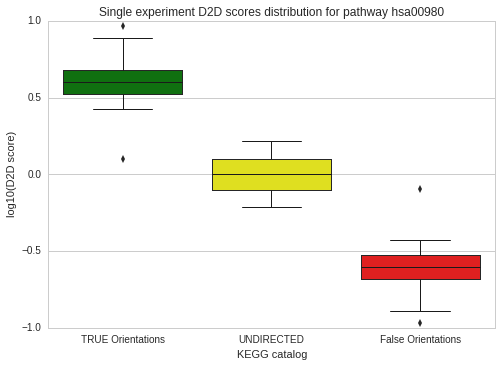

In [24]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="type", y="log(D2D)",data=unoriented,palette=['green','yellow','red'], order=["TRUE_KEGG", "UNDIRECTED_KEGG", "FALSE_KEGG"], linewidth=1)
ax.set_ylim([-1, 1])
plt.setp(ax.lines, color=".1")
ax.set(ylabel='log10(D2D score)')
ax.set(xlabel='KEGG catalog')
ax.set_xticklabels(['TRUE Orientations','UNDIRECTED','False Orientations'])
ax.set_title('Single experiment D2D scores distribution for pathway ' + KEGG_pathway)
plt.savefig(output_library + '/SingleExperimentD2DscoresDistribution.pdf', format='pdf')
plt.show()

# For multiple experiments run from here

Read network and experiments data

In [25]:
# ToUse: Change input and output  paths
# Read original network, sources and terminals
input_library = 'DrugsInfo/input/'
output_library = 'DrugsInfo/output/'
network_filename = input_library + 'consensus.net'
sources_filename = input_library + 'drug_targets.txt'
terminals_filename = input_library + 'drug_expressions.txt'

In [26]:
unoriented = pd.read_table(network_filename, header = 0, usecols = [0,1,2,3], names = ['ID1','ID2','type','conf'])
sources = pd.read_table(sources_filename, header = None, names = ['Experiment','ID'])
terminals = pd.read_table(terminals_filename, header = None, names = ['Experiment','ID'])

Simulate orientation - create an undirected network out of the consensus network

In [27]:
unoriented_complement = unoriented.copy()
unoriented_complement.columns = ['ID2', 'ID1', 'type', 'conf']
unoriented_complement['type'].replace({'TRUE': 'FALSE'}, inplace=True, regex=True)
unoriented = pd.concat([unoriented, unoriented_complement])

In [28]:
# This is actually not needed - but we shuffle the rows just so the known directions will distribute along the dataframe. 
# The results do not depend on it, but it's reasuring to avoid ant location bias of any sort
unoriented = shuffle(unoriented).reset_index(drop=True)

Prepare for network diffusion

In [29]:
# unoriented_network_diffusion is a representation of unoriented with in the class Network
unoriented_network_diffusion = read_ppi(unoriented, is_undirected=True)
unoriented_network_diffusion = unoriented_network_diffusion.normalize()
network_IDs = unoriented[['ID1','ID2']].values.flatten()


15500 genes in the network


In [30]:
unoriented['edge'] = unoriented['ID1'].astype(str) + '.' + unoriented['ID2'].astype(str)

Calc score per experiment

In [31]:
experiments_names = sources['Experiment'].unique()

In [32]:
#experiments_used = list()
#for experiment_name in experiments_names:
#    experiments_used.append(experiment_name)
#    run_diffusion_for_experiment(experiment_name, sources, terminals, unoriented_network_diffusion, unoriented)
    
## Replace NA with 0 - for experiments which did not have sources/terminals in the netowork
#unoriented.fillna(0, inplace=True)

Calculate D2D scores

In [44]:
# ToUse: Change parameter value "size" to the number of experiments you wish to use as features. 
# Ideally use all (in which case uncomment the code above and comment this code box)

# For the sake of the example choose random 10 to run the diffusion
# All results in the paper eacept figure S3 use all the experiments. 
# Please notice that to get the same results all experiments are needed.
experiments_used = list()
for experiment_name in np.random.choice(experiments_names, size = 100, replace=False):
    experiments_used.append(experiment_name)
    run_diffusion_for_experiment(experiment_name, sources, terminals, unoriented_network_diffusion, unoriented)
    
# Replace NA with 0 - for experiments which did not have sources/terminals in the netowork
unoriented.fillna(0, inplace=True)

/usr/local/lib/python3.4/dist-packages/ipykernel-4.3.1-py3.4.egg/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

Train a classifier on the set of directed edges and predict the directions of the remaining edges

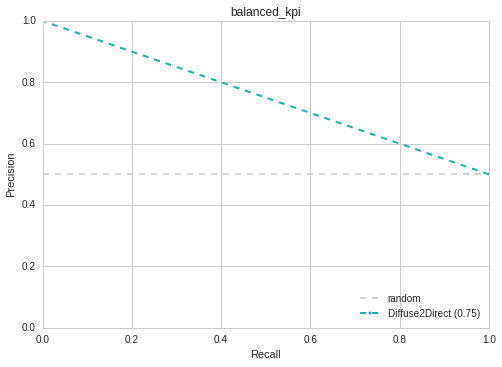

In [34]:
set_name = 'balanced_kpi'
clfLRL1 = linear_model.LogisticRegression(solver='liblinear', penalty = 'l1', C=0.001)

# propagation
recall1, precision1, AUC1, oriented_network, prob = test_crossfold(unoriented,experiments_used,set_name, clfLRL1, 0) 

# middle line
plt.plot([0, 1], [0.5, 0.5], '--', color=(0.8, 0.8, 0.8), label='random')
plt.plot(recall1, precision1, 'o--', marker='o',label= 'Diffuse2Direct (%0.2f)' % AUC1, lw=2, markersize=3, color = 'lightseagreen')#, markeredgecolor = 'dimgrey')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.title(set_name)

params = {'legend.fontsize': 8,
          'figure.figsize': (4.6,2.9),
         'axes.labelsize': 8,
         'axes.titlesize':8,
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params) 
plt.show()

Use a few guiding sources and merge the results

In [35]:
print_auc(unoriented,experiments_used)

PDIs 0.71
KPIs 0.68
STKE 0.62
EGFR 0.53
E3 0.62


[0.70589111142500616,
 0.68346011721391908,
 0.62048508845974426,
 0.52554090176007284,
 0.62388357466251143]

Orient the network

In [36]:
drugs_oriented = create_oriented_network_from_signal(unoriented,experiments_used)

/usr/local/lib/python3.4/dist-packages/ipykernel-4.3.1-py3.4.egg/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel-4.3.1-py3.4.egg/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel-4.3.1-py3.4.egg/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Leave edges with probability below 1+epsilon unoriented

In [37]:
# Find edges with probabilty below 1 + epsilon
epsilon = 0.01
threshold = float(1 + epsilon)
inferred_unoriented = drugs_oriented[abs(drugs_oriented['probability']) <= threshold]

# Create the oppopsite direction
inferred_unoriented_opposite_direction = inferred_unoriented.copy()
inferred_unoriented_opposite_direction.columns = ['edge', 'type', 'conf', 'probability', 'ID2', 'ID1']
inferred_unoriented_opposite_direction['type'].unique()


array(['biogrid'], dtype=object)

In [38]:
drugs_partially_oriented = pd.concat([drugs_oriented, inferred_unoriented_opposite_direction])

In [39]:
drugs_partially_oriented['Predicted_to_be_directed'] = 1

In [40]:
drugs_partially_oriented[abs(drugs_oriented['probability']) <= threshold]['Predicted_to_be_directed'] = 0

/usr/local/lib/python3.4/dist-packages/ipykernel-4.3.1-py3.4.egg/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.4/dist-packages/ipykernel-4.3.1-py3.4.egg/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [41]:
# This is a network oriented using drugs information, there fore  the orientation confodence is only 1 for one network.
# In case more guding sources are available use these to orient copies of the network , and vote for each interaction
drugs_partially_oriented['orientation_confidence'] = 1

In [42]:
drugs_oriented_to_print = drugs_partially_oriented.copy()
drugs_oriented_to_print = drugs_oriented_to_print[['ID1','ID2','type','conf','orientation_confidence','Predicted_to_be_directed']]
drugs_oriented_to_print.columns = ['head','tail','interaction_type','interaction_confidence','orientation_confidence','Predicted_to_be_directed']

In [43]:
drugs_oriented_to_print.to_csv(output_library + 'partially_oriented_network_with_drugs_info.csv', sep = '\t', index = False, header = True)